# Abnormality Detection in Musculoskeletal Radiographs

The objective is to build a machine learning model that can detect an abnormality in the X-Ray radiographs. These models can help towards providing healthcare access to the parts of the world where access to skilled radiologists is limited. According to a study on the Global Burden of Disease and the worldwide impact of all diseases found that, “musculoskeletal conditions affect more than 1.7 billion people worldwide. They are the 2nd greatest cause of disabilities, and have the 4th greatest impact on the overall health of the world population when considering both death and disabilities”. (www.usbji.org, n.d.).

This project attempts to implement deep neural network using DenseNet169 inspired from the Stanford Paper Rajpurkar, et al., 2018.

## XR_HAND Study Type

## Phase 3: Data Preprocessing

As per the paper, i have normalized the each image to have same mean & std of the images in the ImageNet training set. In the paper, they have used variable-sized images to 320 x 320. But i have chosen to scale 224 x 224. Then i have augmented the data during the training by applying random lateral inversions and rotations of up to 30 degrees using 

In [1]:
from keras.applications.densenet import DenseNet169, DenseNet121, preprocess_input
from keras.preprocessing.image import ImageDataGenerator, load_img, image
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, MaxPool2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from keras import regularizers
import pandas as pd
from tqdm import tqdm
import os
import numpy as np
import random
from keras.optimizers import Adam
import keras.backend as K
import cv2
import matplotlib.pyplot as plt

Using TensorFlow backend.


### 3.1 Data preprocessing

In [2]:
#Utility function to find the list of files in a directory excluding the hidden files.
def listdir_nohidden(path):
    for f in os.listdir(path):
        if not f.startswith('.'):
            yield f

### 3.1.1 Creating a csv file containing path to image & csv

In [3]:
def create_images_metadata_csv(category,study_types):
    """
    This function creates a csv file containing the path of images, label.
    """
    image_data = {}
    study_label = {'positive': 1, 'negative': 0}
    #study_types = ['XR_ELBOW','XR_FINGER','XR_FOREARM','XR_HAND','XR_HUMERUS','XR_SHOULDER','XR_WRIST']
    #study_types = ['XR_ELBOW']
    i = 0
    image_data[category] = pd.DataFrame(columns=['Path','Count', 'Label'])
    for study_type in study_types: # Iterate throught every study types
        DATA_DIR = 'data/MURA-v1.1/%s/%s/' % (category, study_type)
        patients = list(os.walk(DATA_DIR))[0][1]  # list of patient folder names
        for patient in tqdm(patients):  # for each patient folder
            for study in os.listdir(DATA_DIR + patient):  # for each study in that patient folder
                if(study != '.DS_Store'):
                    label = study_label[study.split('_')[1]]  # get label 0 or 1
                    path = DATA_DIR + patient + '/' + study + '/'  # path to this study
                    for j in range(len(list(listdir_nohidden(path)))):
                        image_path = path + 'image%s.png' % (j + 1)
                        image_data[category].loc[i] = [image_path,1, label]  # add new row
                        i += 1
    image_data[category].to_csv(category+"_image_data.csv",index = None, header=False)

In [4]:
#New function create image array by study level
def getImagesInArrayNew(train_dataframe):
    images = []
    labels = []
    for i, data in tqdm(train_dataframe.iterrows()):
        img = cv2.imread(data['Path'])
#         #random rotation
#         angle = random.randint(-30,30)
#         M = cv2.getRotationMatrix2D((img_width/2,img_height/2),angle,1)
#         img = cv2.warpAffine(img,M,(img_width,img_height))
        #resize
        img = cv2.resize(img,(img_width,img_height))    
        img = img[...,::-1].astype(np.float32)
        images.append(img)
        labels.append(data['Label'])
    images = np.asarray(images).astype('float32') 
    #normalization
    mean = np.mean(images[:, :, :])
    std = np.std(images[:, :, :])
    images[:, :, :] = (images[:, :, :] - mean) / std
    labels = np.asarray(labels)
    return {'images': images, 'labels': labels}

#### 3.1.1.1 Variables intialization

In [5]:
img_width, img_height = 224, 224
#Keras ImageDataGenerator to load, transform the images of the dataset
BASE_DATA_DIR = 'data/'
IMG_DATA_DIR = 'MURA-v1.1/'

### 3.1.2 XR_HAND ImageDataGenertors

I am going to generate model for every study type and ensemble them. Hence i am preparing data per study type for the model to be trained on.

In [6]:
train_data_dir = BASE_DATA_DIR + IMG_DATA_DIR + 'train/XR_HAND'
valid_data_dir = BASE_DATA_DIR + IMG_DATA_DIR + 'valid/XR_HAND'

train_datagen = ImageDataGenerator(
    rotation_range=30,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    rotation_range=30,
    horizontal_flip=True

)

study_types = ['XR_HAND']

create_images_metadata_csv('train',study_types)
create_images_metadata_csv('valid',study_types)

valid_image_df = pd.read_csv('valid_image_data.csv', names=['Path','Count', 'Label'])
train_image_df = pd.read_csv('train_image_data.csv', names=['Path', 'Count','Label'])

dd={}

dd['train'] = train_image_df
dd['valid'] = valid_image_df

valid_dict = getImagesInArrayNew(valid_image_df)
train_dict = getImagesInArrayNew(train_image_df)

train_datagen.fit(train_dict['images'],augment=True)
test_datagen.fit(valid_dict['images'],augment=True)

validation_generator = test_datagen.flow(
    x=valid_dict['images'],
    y=valid_dict['labels'],
    batch_size = 1
)

train_generator = train_datagen.flow(
    x=train_dict['images'],
    y=train_dict['labels']
)

100%|██████████| 159/159 [00:01<00:00, 146.77it/s]
460it [00:03, 118.54it/s]
5543it [00:43, 127.12it/s]


### 3.2 Building a model

As per the MURA paper, i replaced the fully connected layer with the one that has a single output, after that i applied a sigmoid nonlinearity. In the paper, the optimized weighted binary cross entropy loss. Please see below for the formula,

L(X, y) = -WT,1 * ylog p(Y = 1|X) -WT,0 * (1 - y)log p(Y = 0|X);
p(Y = 1|X) is the probability that the network assigns to the label i, WT,1 = |NT| / (|AT| + |NT|), and WT,0 = |AT| / (|AT| + |NT|) where |AT|) and |NT|) are the number of abnormal images and normal images of study type T in the training set, respectively.

But i choose to use the default binary cross entropy. The network is configured with Adam using default parameters, batch size of 8, initial learning rate = 0.0001 that is decayed by a factor of 10 each time the validation loss plateaus after an epoch.

### 3.2.1 Model paramaters

In [7]:
#model parameters for training
#K.set_learning_phase(1)
nb_train_samples = len(train_dict['images'])
nb_validation_samples = len(valid_dict['images'])
epochs = 10
batch_size = 8
steps_per_epoch = nb_train_samples//batch_size
print(steps_per_epoch)
n_classes = 1

692


In [33]:
def build_model():
    base_model = DenseNet169(input_shape=(None, None,3),
                             weights='imagenet',
                             include_top=False,
                             pooling='avg')
#     i = 0
#     total_layers = len(base_model.layers)
#     for layer in base_model.layers:
#         if(i <= total_layers//2):
#             layer.trainable = True
#             i = i+1

    x = base_model.output
    
#     x = Dense(1000, kernel_regularizer=regularizers.l1_l2(0.01), activity_regularizer=regularizers.l2(0.01))(x)
#     x = Activation('relu')(x)
#     x = Dense(500, kernel_regularizer=regularizers.l1_l2(0.01), activity_regularizer=regularizers.l2(0.01))(x)
#     x = Activation('relu')(x)
    
    predictions = Dense(n_classes,activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [34]:
model = build_model()

In [35]:
#Compiling the model
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['acc', 'mse'])

In [36]:
#callbacks for early stopping incase of reduced learning rate, loss unimprovement
early_stop = EarlyStopping(monitor='val_loss', patience=8, verbose=1, min_delta=1e-4)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=1, min_lr=0.0001)
callbacks_list = [early_stop, reduce_lr]

### 3.2.2 Training the Model

In [37]:
#train the module
model_history = model.fit_generator(
    train_generator,
    epochs=epochs,
    workers=0,
    use_multiprocessing=False,  
    steps_per_epoch = nb_train_samples//batch_size,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples //batch_size,
    callbacks=callbacks_list
)

Epoch 1/10
692/692 [==============================] - 446s 645ms/step - loss: 43.2305 - acc: 0.7307 - mean_squared_error: 0.2052 - val_loss: 2.8462 - val_acc: 0.6140 - val_mean_squared_error: 0.2410
Epoch 2/10
692/692 [==============================] - 392s 566ms/step - loss: 2.8506 - acc: 0.7308 - mean_squared_error: 0.1978 - val_loss: 3.1675 - val_acc: 0.4561 - val_mean_squared_error: 0.3109

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 3/10
692/692 [==============================] - 388s 560ms/step - loss: 0.8541 - acc: 0.7347 - mean_squared_error: 0.1954 - val_loss: 0.9676 - val_acc: 0.5789 - val_mean_squared_error: 0.2634
Epoch 4/10
692/692 [==============================] - 388s 560ms/step - loss: 0.8328 - acc: 0.7308 - mean_squared_error: 0.1970 - val_loss: 0.8954 - val_acc: 0.6667 - val_mean_squared_error: 0.2248
Epoch 5/10
692/692 [==============================] - 388s 560ms/step - loss: 0.8345 - acc: 0.7321 - mean_squared_error: 0.19

In [15]:
model.save("densenet_mura_rs_v3_xr_hand.h5")

### 3.2.3 Visualizing the model

In [ ]:
#There was a bug in keras to use pydot in the vis_utils class. In order to fix the bug, i had to comment out line#55 in vis_utils.py file and reload the module
#~/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/utils
from keras.utils import plot_model 
from keras.utils.vis_utils import *
import keras
import importlib
importlib.reload(keras.utils.vis_utils)
import pydot
plot_model(model, to_file='images/densenet_archi_xr_hand_v3.png', show_shapes=True)


### 3.3 Performance Evaluation

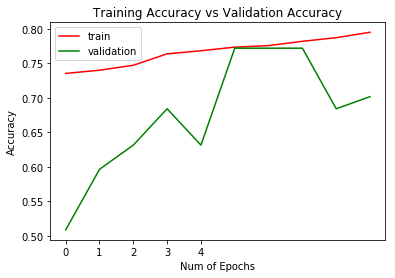

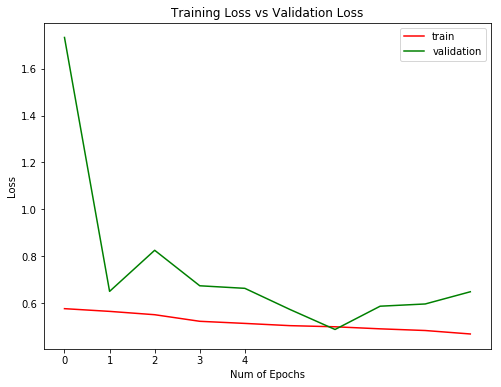

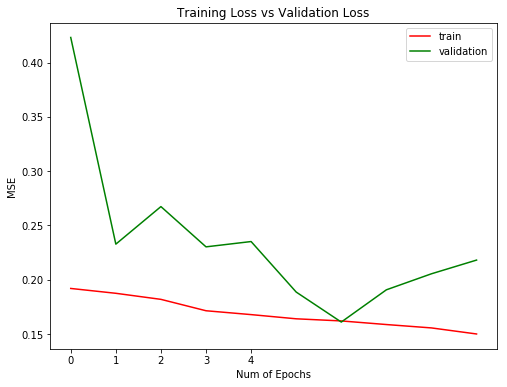

In [16]:
#Now we have trained our model, we can see the metrics during the training proccess
plt.figure(0)
plt.plot(model_history.history['acc'],'r')
plt.plot(model_history.history['val_acc'],'g')
plt.xticks(np.arange(0, 5, 1))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])
 
plt.figure(1)
plt.plot(model_history.history['loss'],'r')
plt.plot(model_history.history['val_loss'],'g')
plt.xticks(np.arange(0, 5, 1))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])

plt.figure(2)
plt.plot(model_history.history['mean_squared_error'],'r')
plt.plot(model_history.history['val_mean_squared_error'],'g')
plt.xticks(np.arange(0, 5, 1))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("MSE")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])
 
plt.show()

In [39]:
#Now we evaluate the trained model with the validation dataset and make a prediction. 
#The class predicted will be the class with maximum value for each image.
ev = model.evaluate_generator(validation_generator, steps=nb_validation_samples,  workers=0, use_multiprocessing=False)
ev[1]


0.5695652173913044

In [18]:
#pred = model.predict_generator(validation_generator, steps=1, batch_size=1, use_multiprocessing=False, max_queue_size=25, verbose=1)
validation_generator.reset()
#pred = model.predict_generator(validation_generator,steps=nb_validation_samples)
pred_batch = model.predict_on_batch(valid_dict['images'])

In [27]:
predictions = []
for p in pred_batch:
    if(p > 0.4):
        predictions+=[1]
    else:
        predictions+=[0]

In [28]:
error = np.sum(np.not_equal(predictions, valid_dict['labels'])) / valid_dict['labels'].shape[0]  
pred = predictions

Confusion Matrix


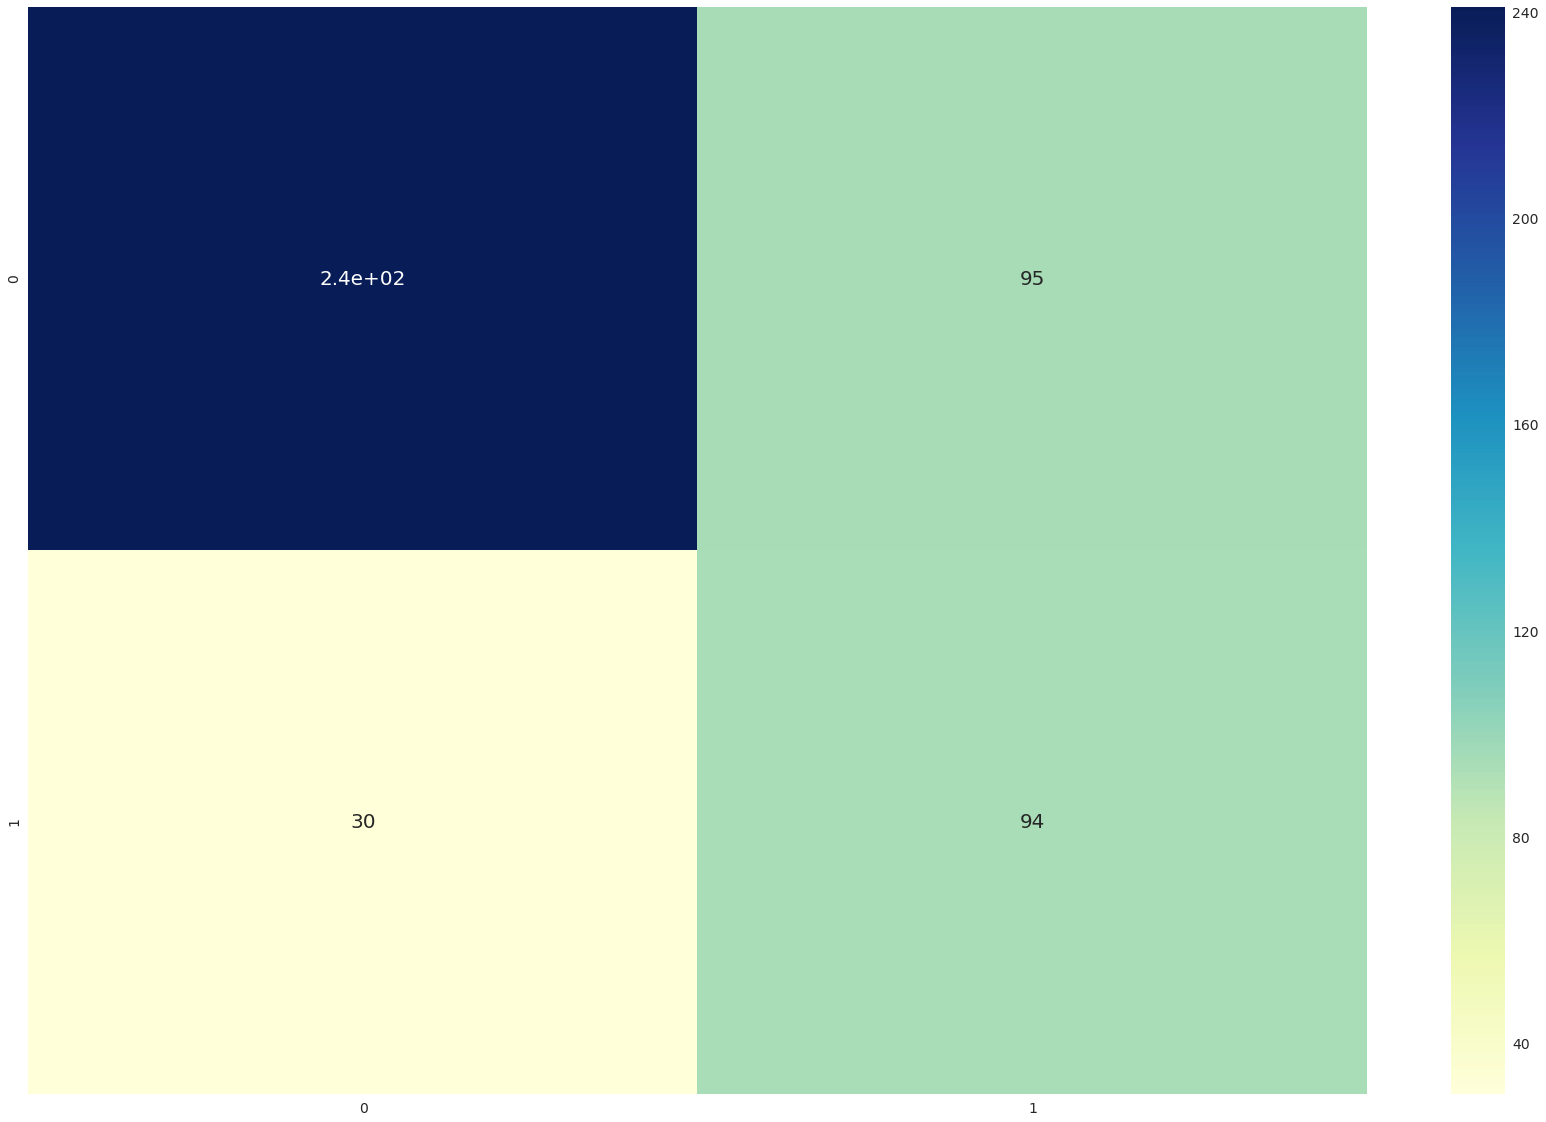

In [29]:
print('Confusion Matrix')
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score
import seaborn as sn
cm = confusion_matrix( pred ,valid_dict['labels'])
plt.figure(figsize = (30,20))
sn.set(font_scale=1.4) #for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 20},cmap="YlGnBu") # font size
plt.show()

In [30]:
print()
print('Classification Report')
print(classification_report(valid_dict['labels'], pred, target_names=["0","1"]))


Classification Report
             precision    recall  f1-score   support

          0       0.72      0.89      0.79       271
          1       0.76      0.50      0.60       189

avg / total       0.73      0.73      0.71       460



In [31]:
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score
cohen_kappa_score(valid_dict['labels'], pred)

0.40787576718704943

### ROC Curve

In [24]:
from sklearn.metrics import roc_curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve(valid_dict['labels'], pred_batch)

In [25]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

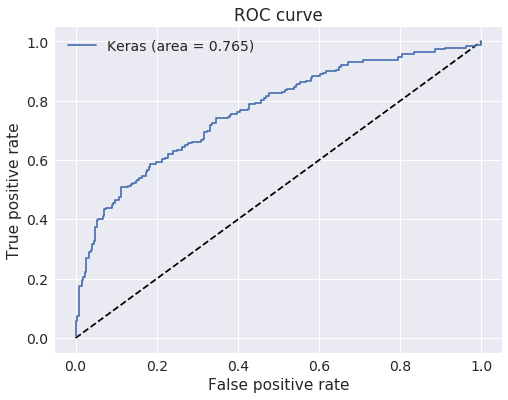

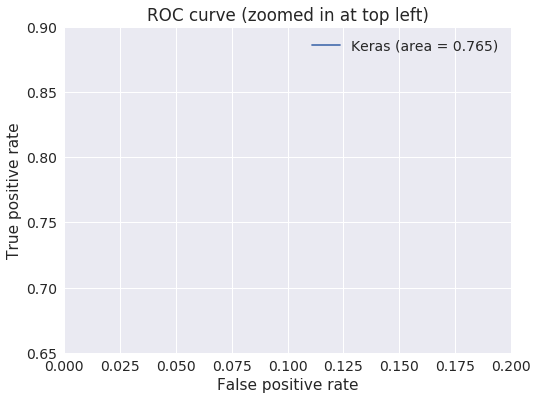

In [26]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

plt.figure(2)
plt.xlim(0.0, 0.2)
plt.ylim(0.65, 0.9)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()